In [7]:
from google.colab import files
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image as im
import cv2 as cv
import random

In [2]:
uploaded = files.upload()

Saving Bi_mp-23152_computed Profile_0.7.txt to Bi_mp-23152_computed Profile_0.7.txt
Saving Bi_mp-23152_computed Profile_0.0.txt to Bi_mp-23152_computed Profile_0.0.txt
Saving Bi_mp-23152_computed Profile_0.1.txt to Bi_mp-23152_computed Profile_0.1.txt
Saving Bi_mp-23152_computed Profile_0.2.txt to Bi_mp-23152_computed Profile_0.2.txt
Saving Bi_mp-23152_computed Profile_0.3.txt to Bi_mp-23152_computed Profile_0.3.txt
Saving Bi_mp-23152_computed Profile_0.4.txt to Bi_mp-23152_computed Profile_0.4.txt
Saving Bi_mp-23152_computed Profile_0.5.txt to Bi_mp-23152_computed Profile_0.5.txt
Saving Bi_mp-23152_computed Profile_0.6.txt to Bi_mp-23152_computed Profile_0.6.txt
Saving Bi_mp-23152_computed Profile_0.8.txt to Bi_mp-23152_computed Profile_0.8.txt
Saving Bi_mp-23152_computed Profile_0.9.txt to Bi_mp-23152_computed Profile_0.9.txt
Saving Bi_mp-23152_computed Profile_1.0.txt to Bi_mp-23152_computed Profile_1.0.txt


In [3]:
files_to_open = []
file_name_ending = "Bi_mp-23152_computed Profile_"
for val in range(0,11,1):
  #print(val/10)
  file_name = file_name_ending + str(val/10) + ".txt" 
  files_to_open.append(file_name)

In [5]:
#files_to_open=["Bi_mp-23152_computed Profile.txt"]

In [4]:
#VALUES
scale = 5
resolution = 250

In [10]:
one_hot_vecs = []
for i in range(0,len(files_to_open)):
  one_hot_vec =[0] * len(files_to_open)
  one_hot_vec[i] = 1
  one_hot_vecs.append(one_hot_vec)
  

print(len(one_hot_vec))

11


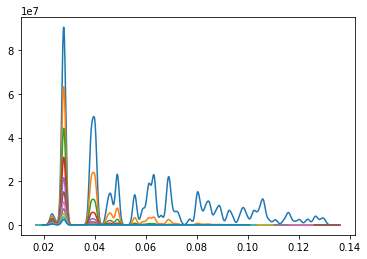

In [11]:
radii = []
intenisties = []
for file_name in files_to_open:
  file = open(file_name, "r")
  array_vals = []
  for line in file:
    data_point = line.split()

    array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),float(data_point[1])])
  #print(array_vals)
  radius,intensity = zip(*array_vals)
  
  #angle_rad = angle_deg)/2
  radii.append(radius)
  intenisties.append(intensity)
  #print(X)
  
for i in range(0,len(radii)):
  plt.plot(radii[i],intenisties[i])


In [12]:
#source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
#adding an invert option because it looks cool
invert = False

X, Y = np.ogrid[:resolution,:resolution]
centre_val = resolution/2
images = []
array_ones = np.ones((resolution,resolution))
dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)
for i in range(0,len(radii)):
  if invert:
    base_img = np.ones((resolution,resolution))*256
  else:
    base_img = np.zeros((resolution,resolution))

  
  radius = radii[i]
  intensity = intenisties[i]
  
  min_rad = radius[0]
  radius_adjustment_value = (resolution/2)*0.1/min_rad

  prev_rad = radius[0]*radius_adjustment_value
  max_intensity = max(intensity)
  for j in range(0,len(radius)):
    #print(radius[j])
    
    curr_rad = radius[j]*radius_adjustment_value
    #print("adjusted radius: {}".format(curr_rad))
       
    mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)
    #mask = (dist_from_center <= 20) & (dist_from_center > 19)
    unscaled_donut = np.copy(array_ones)
    unscaled_donut[~mask]=0
    if invert:
      base_img -= unscaled_donut*intensity[j]*200/max_intensity
    else:
      base_img += unscaled_donut*intensity[j]*200/max_intensity
    prev_rad = curr_rad

  #image = im.fromarray(base_img)
  blurry_img = cv.GaussianBlur(base_img,(5,5),0)
  #images.append(blurry_img)
  for q in range(0,15):
    M = np.float32([
    [1, 0, random.randint(-10,10)],
    [0, 1, random.randint(-10,10)]
    ])
    images.append([cv.warpAffine(blurry_img, M, (resolution,resolution)),one_hot_vecs[i]])


  #plt.imsave('DR.png', image, cmap='gray')
"""
for base_img in images:
    plt.imshow(im.fromarray(base_img[0]))
    print(base_img[1])
    plt.show()
"""
#print(len(images))
print(images[0][0].shape)

(250, 250)


In [13]:
X,Y = zip(*images)

X_array = np.array(X).reshape(-1,resolution,resolution,1)
Y_array = np.array(Y).reshape(-1,11)

print(X_array.shape)
print(Y_array.shape)
#plt.imshow(X_array[0],cmap='gray')
#plt.show()

(165, 250, 250, 1)
(165, 11)


In [14]:
#source: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
# define cnn model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(resolution, resolution, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(11, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model


In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization

def build_driving_model():
  #resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(resolution, resolution, 1))

  #for layer in resnet.layers[:-4]:
  #    layer.trainable = False
  
  """
  for layer in resnet.layers:
      print(layer, layer.trainable)
  """
  model = Sequential()
  #model.add(resnet)
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(200, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(50, activation='tanh'))
  #model.add(Dropout(0.5))
  model.add(Dense(11, activation='softmax'))
  return model

def build_alexnet_model():
  #image_shape = (80,60,1)
  np.random.seed(1000)
  #https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer
  model = tf.keras.Sequential([
    #tf.keras.layers.InputLayer(input_shape=image_shape),
    tf.keras.layers.Conv2D(filters=96, kernel_size=(5,5),strides=(2,2),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),activation=tf.nn.relu), 
    #tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    #tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(11, activation=tf.keras.activations.linear)])
  
  return model


In [34]:
model = build_alexnet_model()
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.fit(X_array,Y_array,batch_size=15,epochs=100,validation_split=0.1)

Epoch 1/100
10/10 [==============================] - 4s 259ms/step - loss: 5.1439 - accuracy: 0.0946 - val_loss: 2.5782 - val_accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 1s 102ms/step - loss: 3.5831 - accuracy: 0.1014 - val_loss: 2.9968 - val_accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 1s 102ms/step - loss: 3.5280 - accuracy: 0.1014 - val_loss: 3.3299 - val_accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 1s 101ms/step - loss: 3.4973 - accuracy: 0.1014 - val_loss: 3.8030 - val_accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 1s 102ms/step - loss: 3.4626 - accuracy: 0.1014 - val_loss: 5.0846 - val_accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 1s 101ms/step - loss: 3.4229 - accuracy: 0.1014 - val_loss: 14.4903 - val_accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 1s 102ms/step - loss: 3.3805 - accuracy: 0.1014 - val_loss: 14.4